In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [5]:
# Selected features 
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']


# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.head()

minimum_nights  number_of_reviews  reviews_per_month  \
27357               3                  4               2.45   
17998               1                 35               2.75   
11703               3                 16               0.62   
25026               1                  0               0.00   
31283               1                  0               0.00   

       calculated_host_listings_count  availability_365  Host Response Rate  \
27357                               1                23                -2.0   
17998                              10               156                -2.0   
11703                               4                37                -2.0   
25026                              10               284                -2.0   
31283                               1                43                -2.0   

       Accommodates  Bathrooms  Bedrooms  Beds  ...  \
27357          -2.0       -2.0      -2.0  -2.0  ...   
17998          -2.0       -2.0      -2.0  -2.0  ...   
11703          -2.0       -2.0      -2.0  -2.0  ...   
25026          -2.0       -2.0      -2.0  -2.0  ...   
31283          -2.0       -2.0      -2.0  -2.0  ...   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
27357                          0                             0   
17998                          0                             0   
11703                          0                             1   
25026                          0                             0   
31283                          0                             1   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
27357                              1                           0   
17998                              1                           0   
11703                              0                           0   
25026                              1                           0   
31283                              0                           0   

       neighbourhood_group_Staten Island         x         y         z  \
27357                                  0  0.208824 -0.728089  0.652900   
17998                                  0  0.208893 -0.728482  0.652440   
11703                                  0  0.209660 -0.728891  0.651737   
25026                                  0  0.208956 -0.727793  0.653188   
31283                                  0  0.209579 -0.728689  0.651989   

       text_encoding_tsne_1  text_encoding_tsne_2  
27357             -7.517027             -0.076676  
17998             -7.517027             -0.076676  
11703             -7.517027             -0.076676  
25026             -7.517027             -0.076676  
31283             -7.517027             -0.076676  

[5 rows x 30 columns]

# Gradient Boosting Regressor

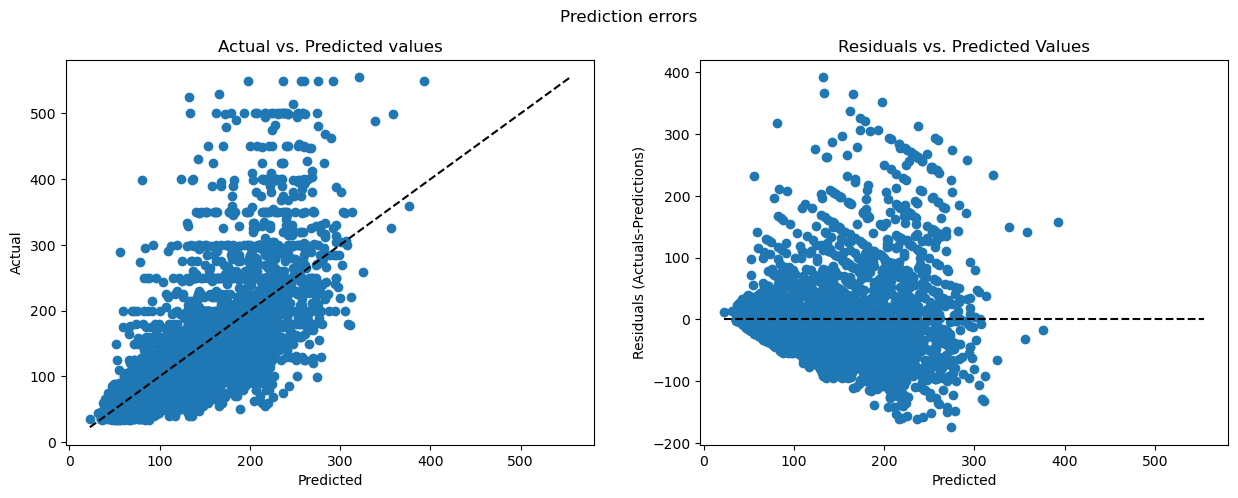

R²: 0.518869162674491
MAE: 43.62549053277289
MSE: 4304.3226874473885
RMSE: 65.60733714644566
MAPE: 0.34508940701168855
error_ratio_rmse: 0.4743517090134031
error_ratio_mae: 0.31541938586193585


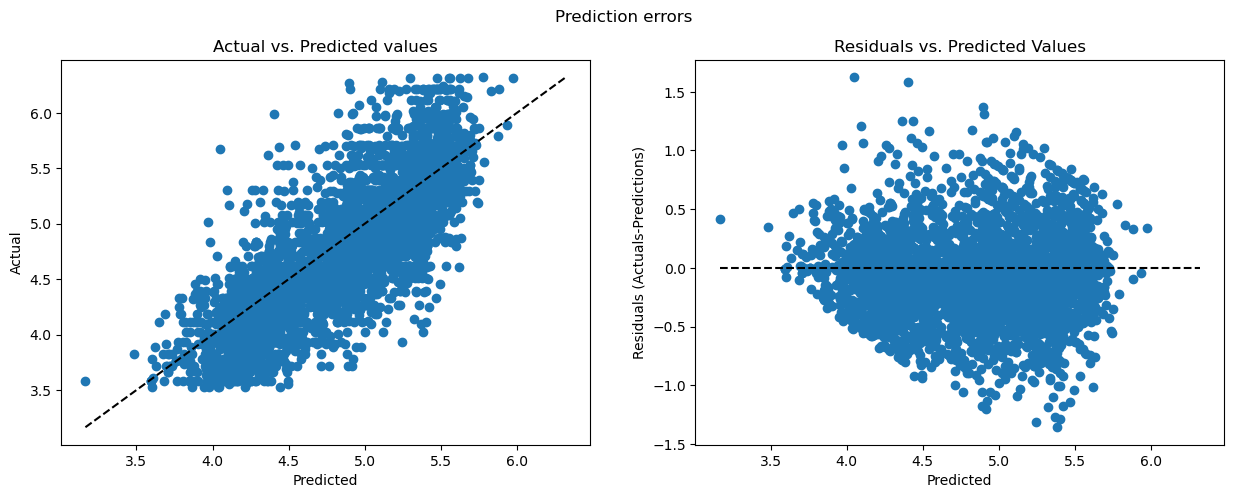

R²: 0.6150904400252009
MAE: 0.3058889371750359
MSE: 0.14958754762332038
RMSE: 0.3867654943545512
MAPE: 0.06596767362303486
error_ratio_rmse: 0.08162834847339581
error_ratio_mae: 0.06455903932058381


In [6]:
model_init = GradientBoostingRegressor(criterion = "squared_error").fit(X_train_np, y_train_np)
y_pred = np.maximum(0,model_init.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [18]:
space={
        'n_estimators': hp.choice('n_estimators', range(50, 400)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'min_samples_split': hp.choice('min_samples_split', range(2, 20)),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
        'loss': hp.choice('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']),
        'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error']),
        'warm_start': hp.choice('warm_start', [True, False]),
        'random_state': hp.choice('random_state',range(0,400))
}


def objective(space):
    mod=GradientBoostingRegressor(**space)
    
    mod.fit(X_train_np, y_train_np)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.4484891310049387                                                                                                 
MAE: 49.01290069419348                                                                                                 
MSE: 4933.960913802783                                                                                                 
RMSE: 70.24215909126643                                                                                                
MAPE: 0.4108713415189549                                                                                               
error_ratio_rmse: 0.5078622248508481                                                                                   
error_ratio_mae: 0.354371236803877                                                                                     
SCORE:                                                                                                                 
70.24215909126643                       

MAE: 40.51840519749577                                                                                                 
MSE: 4450.990419700179                                                                                                 
RMSE: 66.7157434171289                                                                                                 
MAPE: 0.28084663686498845                                                                                              
error_ratio_rmse: 0.48236566647072476                                                                                  
error_ratio_mae: 0.29295465397456594                                                                                   
SCORE:                                                                                                                 
66.7157434171289                                                                                                       
R²: 0.5326228085710061                  

MSE: 7583.899424696285                                                                                                 
RMSE: 87.08558677930743                                                                                                
MAPE: 0.6667653727017642                                                                                               
error_ratio_rmse: 0.6296429441571608                                                                                   
error_ratio_mae: 0.5028358594093242                                                                                    
SCORE:                                                                                                                 
87.08558677930743                                                                                                      
R²: 0.5527035982229695                                                                                                 
MAE: 41.524854517966105                 

RMSE: 67.63962901333639                                                                                                
MAPE: 0.2839393644039956                                                                                               
error_ratio_rmse: 0.48904550946626735                                                                                  
error_ratio_mae: 0.29166783478524677                                                                                   
SCORE:                                                                                                                 
67.63962901333639                                                                                                      
R²: 0.5109791720076943                                                                                                 
MAE: 41.87573137371854                                                                                                 
MSE: 4374.908613761367                  

MAPE: 0.3168847274940275                                                                                               
error_ratio_rmse: 0.4505447101226969                                                                                   
error_ratio_mae: 0.29446501276139586                                                                                   
SCORE:                                                                                                                 
62.314603562927594                                                                                                     
R²: 0.17535035268596344                                                                                                
MAE: 69.6836473468944                                                                                                  
MSE: 7377.532078094262                                                                                                 
RMSE: 85.8925612500539                  

error_ratio_rmse: 0.45591277027958343                                                                                  
error_ratio_mae: 0.29852248394350256                                                                                   
SCORE:                                                                                                                 
63.057057159790894                                                                                                     
R²: -0.6507745041670461                                                                                                
MAE: 112.97103532835399                                                                                                
MSE: 14768.261767721047                                                                                                
RMSE: 121.52473726662011                                                                                               
MAPE: 1.3694940570257526                

error_ratio_mae: 0.3014978124905001                                                                                    
SCORE:                                                                                                                 
63.40530192964979                                                                                                      
R²: 0.46942229488693676                                                                                                
MAE: 41.77547542606223                                                                                                 
MSE: 4746.687338244417                                                                                                 
RMSE: 68.89620699461196                                                                                                
MAPE: 0.2884142774258176                                                                                               
error_ratio_rmse: 0.49813077246964427   

In [28]:
best_hyperparams =  {'criterion': 'friedman_mse',
                     'learning_rate': 0.017145618566948934,
                     'loss': 'squared_error',
                     'max_depth': 12,
                     'max_features': 1,
                     'min_samples_leaf': 11,
                     'min_samples_split': 2,
                     'n_estimators': 301,
                     'random_state': 346,
                     'subsample': 0.9433916678700203,
                     'warm_start': 1}

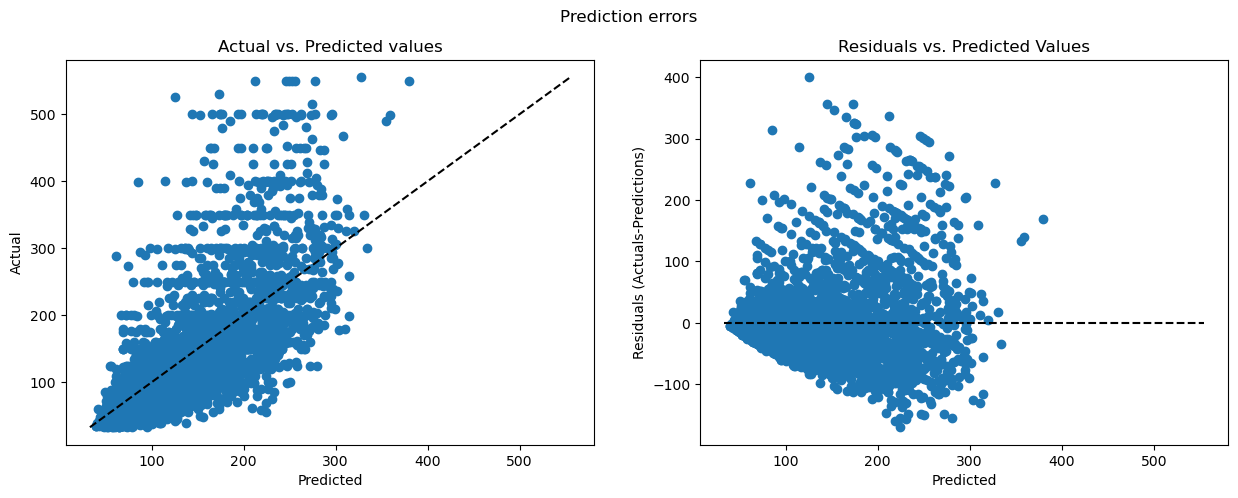

R²: 0.5359911869261453
MAE: 42.52233386554914
MSE: 4151.144566811651
RMSE: 64.42937658251593
MAPE: 0.3375701698741177
error_ratio_rmse: 0.4658348627130693
error_ratio_mae: 0.3074433838907072


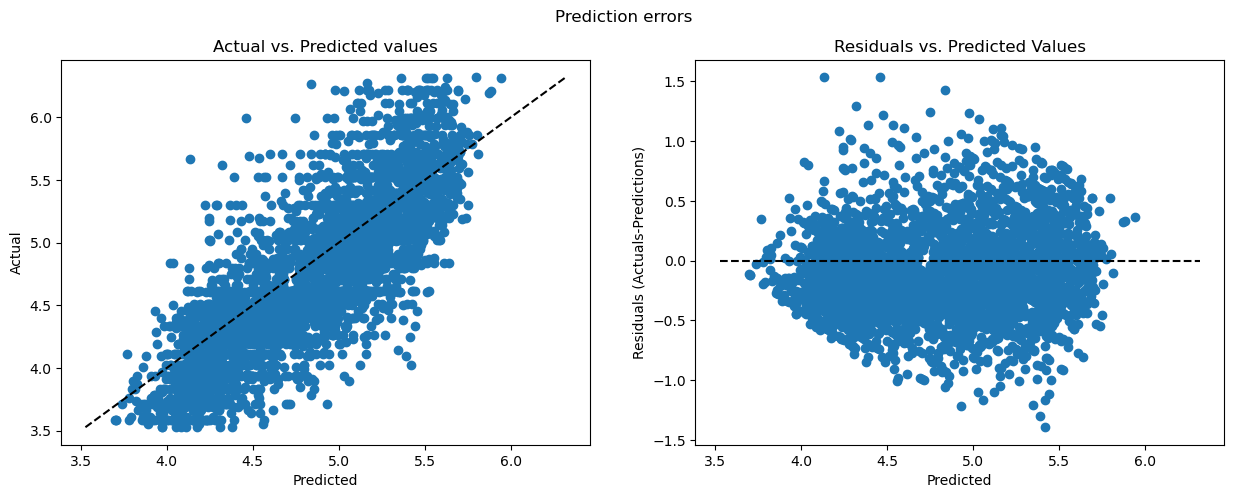

R²: 0.6308083108839497
MAE: 0.2994039108593597
MSE: 0.14347910553688784
RMSE: 0.37878635869958127
MAPE: 0.06472829121122596
error_ratio_rmse: 0.07994432113572615
error_ratio_mae: 0.06319034951841163


In [29]:
model_tuned = GradientBoostingRegressor(**best_hyperparams)

model_tuned.fit(X_train_np, y_train_np)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

In [30]:
sk_gradboost_params = model_tuned.get_params()

# Save the parameters as a JSON file
with open('saved_models/sk_gradient_boosting_params.json', 'w') as f:
    json.dump(sk_gradboost_params, f)